In [1]:
import torch
import numpy as np
import tritrain
import mapping
import matplotlib.pyplot as plt
from dataset import read_all_of_huaweicup, tensor_file_name_converter

## 不同轮次的输入数据可放在不同文件夹中便于管理，这里用户可以自定义
PathSet = {0: "./Test", 1: "./CompetitionData1", 2: "./CompetitionData2", 3: "./CompetitionData3"}
PrefixSet = {0: "Round0", 1: "Round1", 2: "Round2", 3: "Round3"}

Ridx = 1 # 设置比赛轮次索引，指明数据存放目录。0:Test; 1: 1st round; 2: 2nd round ...
Didx = 3 # 设置为第几组数据
model_file = './CompetitionData1/Round1NET11721481719.3856256.pth'

PathRaw = PathSet[Ridx]
Prefix = PrefixSet[Ridx]


In [2]:
# 网络给出的嵌入向量为 64 和 anch_pos

embedding_dim = 64
bs_pos, tol_samp_num, anch_samp_num, port_num, ant_num, sc_num, anch_pos, H, d_cs, d_geo = read_all_of_huaweicup(Ridx, Didx)

H_real = H.real
H_imag = H.imag
H_combined = np.stack((H_real, H_imag), axis=2)
H_combined = H_combined.reshape(tol_samp_num, 4, ant_num, sc_num)


Processing Round 1 Case 3
Loading configuration data file
Loading input position file
Loading input CSI data of Case 3
Loading Channel CSI succeed
Loading DCS data succeed
Loading GEO data succeed


Model loaded from ./CompetitionData1/Round1NET11721481719.3856256.pth
Start mapping embeddings to coords through PyTorch
Known indices: [1 2 3 4 5]
Known embeddings (first 5): tensor([[ 0.5915,  0.2401],
        [ 2.1750, -0.5503],
        [ 2.2482, -0.2698],
        [ 0.2886,  0.0911],
        [ 0.6751,  0.4352]], device='cuda:0')
Known coordinates (first 5): tensor([[  -3.0880, -143.1513],
        [  48.6656, -165.7083],
        [-123.0845, -121.0140],
        [ -93.4664, -126.8723],
        [   4.7062,  -59.8035]], device='cuda:0')
Iteration 0: Loss = 37796784.0
Iteration 2000: Loss = 20043970.0
Iteration 4000: Loss = 12996887.0
Iteration 6000: Loss = 10649708.0
Iteration 8000: Loss = 9863170.0
Iteration 10000: Loss = 9410041.0
Iteration 12000: Loss = 9044022.0
Iteration 14000: Loss = 8845371.0
Iteration 16000: Loss = 8787152.0
Iteration 18000: Loss = 8783015.0
Optimal A: [[ 0.83761066 -1.0131661 ]
 [ 3.097928    1.9896417 ]]
Optimal b: [[ -43.825127 -109.50973 ]]
Mapped Coordinates

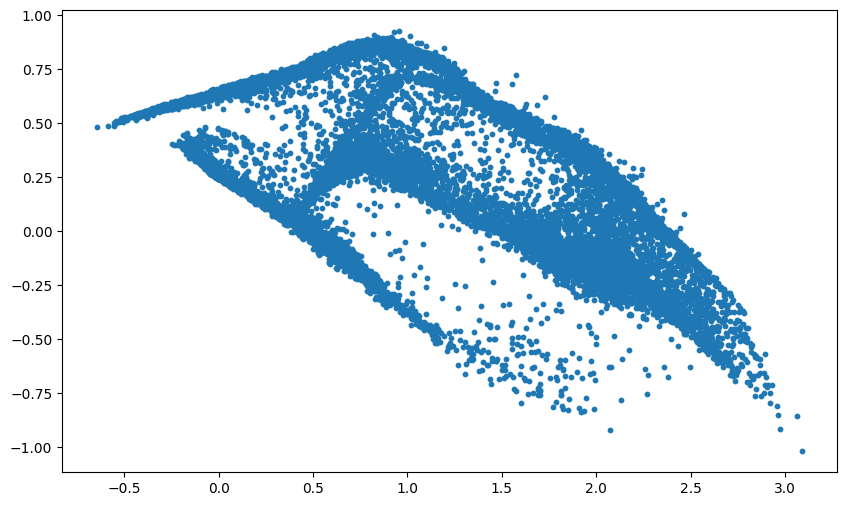

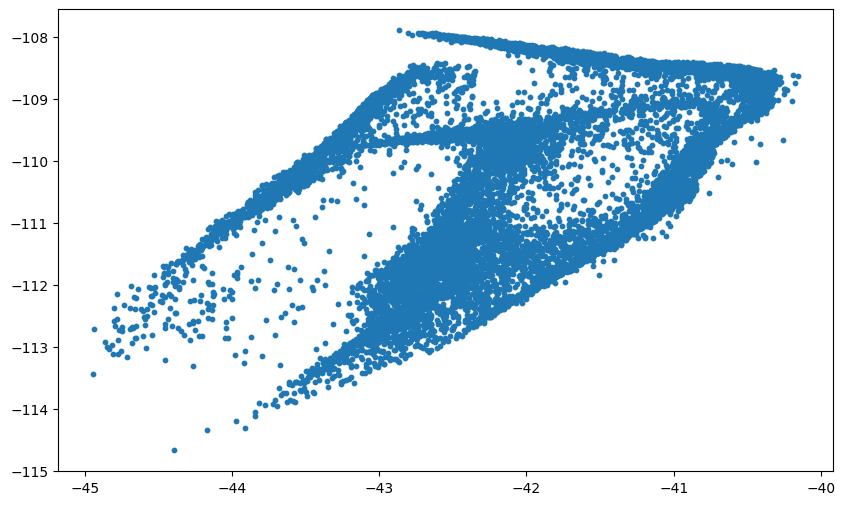

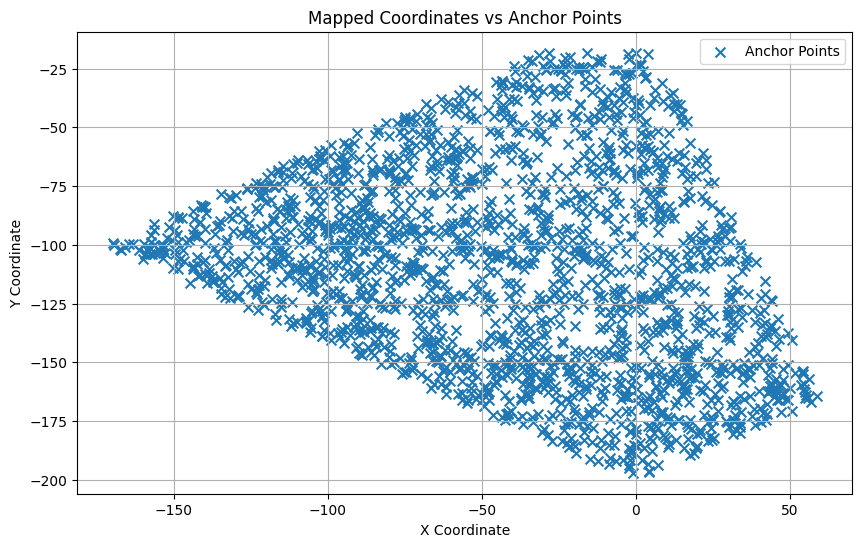

Differences between Mapped and Real Coordinates: [[-39.49799854  33.51994471]
 [-92.37360018  52.90004957]
 [ 80.30661838   8.6896134 ]
 [ 50.16510377  17.25141987]
 [-46.61764562 -49.52431219]]
Total deviation of anchor points: 156206.68101116334
Writing output position file


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 在需要使用模型的地方加载模型
triplet_net_loaded = tritrain.TripletNet().to(device)
triplet_net_loaded.load_state_dict(torch.load(model_file))
triplet_net_loaded.eval()  # 切换到评估模式

print("Model loaded from "+model_file)
embeddings = mapping.map_embeddings(triplet_net_loaded, H_combined, device)

# 调用函数
mapped_coords = mapping.map_embeddings_to_coords(embeddings, anch_pos,device)

# 输出前五个映射结果
print("Mapped Coordinates for the first 5 points:")
print(mapped_coords[:5])

# 验证转换效果
if mapped_coords is not None:
    print("Original Known Coordinates:")
    print(anch_pos[:5, 1:])
    print("Mapped Coordinates for Known Embeddings:")
    mapped_known_coords = mapped_coords[anch_pos[:5, 0].astype(int)]
    print(mapped_known_coords[:5])
    # 绘制结果
    plt.figure(figsize=(10, 6))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], s=10, label='Embeddings Points')
    plt.figure(figsize=(10, 6))
    plt.scatter(mapped_coords[:, 0], mapped_coords[:, 1], s=10, label='Mapped Points')
    plt.figure(figsize=(10, 6))
    plt.scatter(anch_pos[:, 1], anch_pos[:, 2], s=50, label='Anchor Points', marker='x')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Mapped Coordinates vs Anchor Points')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 计算误差差值
    indices = anch_pos[:, 0].astype(int)
    real_coords = anch_pos[:, 1:]
    diff = mapped_coords[indices] - real_coords
    # 计算所有锚点偏差的总和
    total_diff_sum = np.sum(np.abs(diff))  # 可以改为 np.linalg.norm(diff) 求范数
    # 打印结果
    print("Differences between Mapped and Real Coordinates:",diff[:5])
    print("Total deviation of anchor points:", total_diff_sum)


    # 回填锚点位置信息
    for idx in range(anch_samp_num):
        rowIdx = int(anch_pos[idx][0] - 1)
        mapped_coords[rowIdx] = np.array([anch_pos[idx][1], anch_pos[idx][2]])

    # 输出结果：各位参赛者注意输出值的精度
    print('Writing output position file')
    with open(PathRaw + '/' + Prefix + 'OutputPos' + str(Didx) + '.txt', 'w') as f:
        np.savetxt(f, mapped_coords, fmt='%.4f %.4f')

else:
    print("Mapping failed.")
